# Lung Cancer Subclassification Using FastAI and HuggingFace

#### About This Data:

This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.

There are five classes in the dataset, each with 5,000 images, being:

*   Lung benign tissue
*   Lung adenocarcinoma
*   Lung squamous cell carcinoma
*   Colon benign tissue
*   Colon adenocarcinoma

All images are de-identified, HIPAA compliant, validated, and freely available for download to AI researchers.



*   [Dataset Location](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images)
*   [Original Paper](https://arxiv.org/abs/1912.12142v1)

Citation:
Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019



# Data Wrangling and EDA

We first install libraries not preinstalled on Colab

In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 12.5 MB/s 
     |████████████████████████████████| 163 kB 34.0 MB/s 


Import our libraries

In [29]:
import numpy as np
import torch
import splitfolders
import timm
from fastai.vision.augment import *
from fastai.vision.all import *
from fastai.vision import *
from fastai.vision.learner import vision_learner
from fastai.vision.widgets import *
from fastai.metrics import *
from fastai.interpret import ClassificationInterpretation
from fastai.callback.all import *
from fastai.vision.data import *
from torchvision.models.resnet import resnet18, resnet34, resnet50



Check our GPU instance. This is important as we need a GPU to train our model.

In [6]:
torch.cuda.get_device_name(0)

'Tesla T4'

Now that we're set up, we can move on to wrangling our data.

1.   We first download our data and upload to Google Drive.
2.   We mount our Drive in Colab.
3.  We then remove images of colon tissue, leaving only lung tissue.



We can confirm there are 3 remaining classes in our Drive.

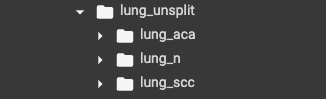

We create a variable for the path to our input folder.

In [3]:
input = '/content/drive/MyDrive/lung_unsplit'

We use "splitfolders" to split into training, validation, and test sets to the named output folder. 70% of our images will become training data, 20% of our images will become validation data, and 10% will be set aside as test data.

In [ ]:
splitfolders.ratio(input, output='/content/drive/MyDrive/lung_split', 
                   seed=42, ratio=(.7,.2,.1), group_prefix=None)

Copying files: 15000 files [04:00, 62.39 files/s]


We can confirm our split has taken place as planned.

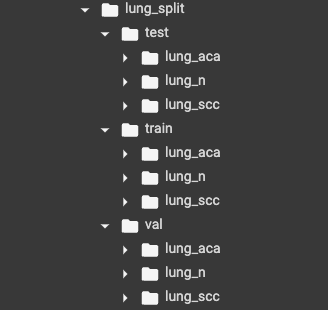


We create a variable for our split dataset.

In [7]:
path = '/content/drive/MyDrive/lung_split'

Let's create variables for our transformations and batch size.

In [8]:
tfms = aug_transforms(do_flip=True, max_rotate=10.0)
bs = 64

Let's create our DataLoaders. We will be resizing these images to 224 x 224 as the CNNs we plan to utilize for transfer learning were trained on 224 x 224 image resolution.

We choose to squish the image, rather than crop or zoom, so no image data is lost.

In [9]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='val', ds_tfms=tfms, 
                                   num_workers = 4, item_tfms=Resize(224, ResizeMethod.Squish), bs=bs)

We can now check our classes.

In [10]:
dls.vocab

['lung_aca', 'lung_n', 'lung_scc']

As expected, our three desired classes are present.

*   Lung adenocarcinoma: 'lung_aca'
*   Lung benign tissue: 'lung_n'
*   Lung squamous cell carcinoma: 'lung_scc'







Let's check the number of images in our train and validation sets.


In [11]:
print(len(dls.train_ds), len(dls.valid_ds))

10500 3000


We started with 15,000 images. 70% to train would be 10,500 images. 20% to validation would be 3,000 images. The remaining 10%, or 1,500 images, are set aside to test our deployed model.

Our classes are also of a similar size, so we can conclude the data is balanced.

Let's view our image data so far. We can accomplish this by showing a batch size that we specify.

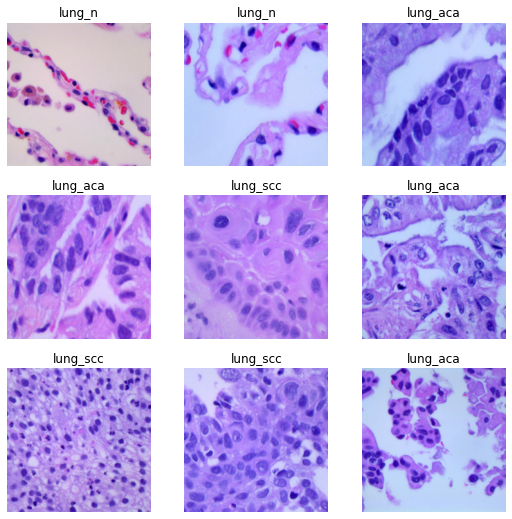

In [12]:
dls.show_batch(max_n=9)

Let's build our model using transfer learning. First, we create our learner.



In [13]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We can use "lr_find" to pick a good learning rate.

SuggestedLRs(valley=0.0004786300996784121)

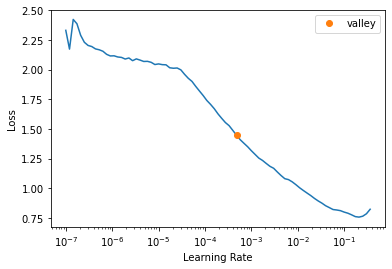

In [14]:
learn.lr_find()

We use "fine_tune" to train a model without starting from scratch. Rather than initialize a model with random weights, we will use a model pre-trained on ImageNet. We will leverage the features this model has already learned and train the last few layers on our particular dataset.

In [15]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.150891,0.047450,0.981333,12:22


epoch,train_loss,valid_loss,accuracy,time
0,0.063862,0.019393,0.993333,03:49
1,0.011238,0.004528,0.999000,03:50


After two epochs, it seems likely our model may start to overfit. We conclude training here.

Let's visualize our loss by plotting it.

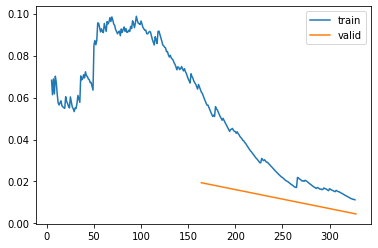

In [16]:
learn.recorder.plot_loss(with_valid=True)

At roughly 300 batches processed, our training and validation loss are at their lowest.

Let's view some predictions.

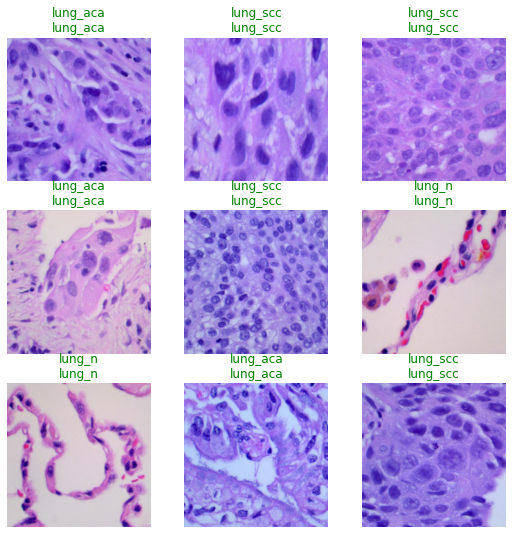

In [17]:
learn.show_results()

We can also make predictions on individual images. Let's try a few from our test set.

In [24]:
learn.predict('/content/drive/MyDrive/lung_split/test/lung_scc/lungscc101.jpeg')

('lung_scc', TensorBase(2), TensorBase([9.7314e-07, 1.1678e-09, 1.0000e+00]))

The predict method returns the decoded prediction (lung_scc here,) the index of the predicted class, and the probabilities of all classes in order of their index labels. In this instance, the model correctly predicted lung squamous cell carcinoma.

The predict method will also take a PIL image. Let's try that. 

In [31]:
im = PILImage.create('/content/drive/MyDrive/lung_split/test/lung_scc/lungscc1000.jpeg')

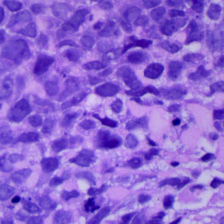

In [36]:
im.thumbnail((224, 224))
im

In [37]:
learn.predict(im)

('lung_scc', TensorBase(2), TensorBase([1.4160e-06, 2.9778e-08, 1.0000e+00]))

Our model correctly predicted lung squamous cell carcinoma using a PIL image.

Let's also interpret our model using a confusion matrix.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

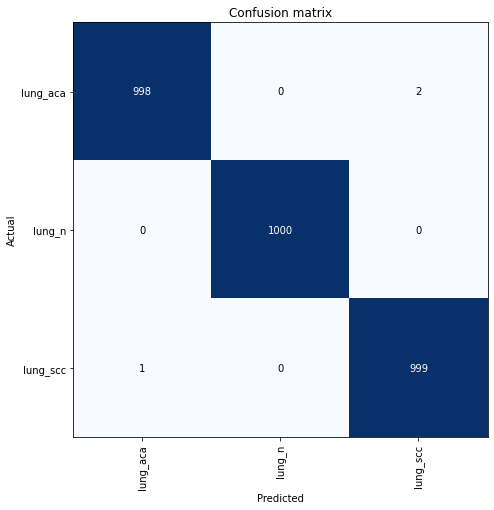

In [20]:
interp.plot_confusion_matrix(figsize=(7,7))

Our model is performing well and has only misclassified cancerous tissue. This is encouraging, as the model should not fail diagnose cancerous tissue or misdiagnose benign tissue.

We can use our interpretation object to see where the model made the worst predictions and where it was least confident.

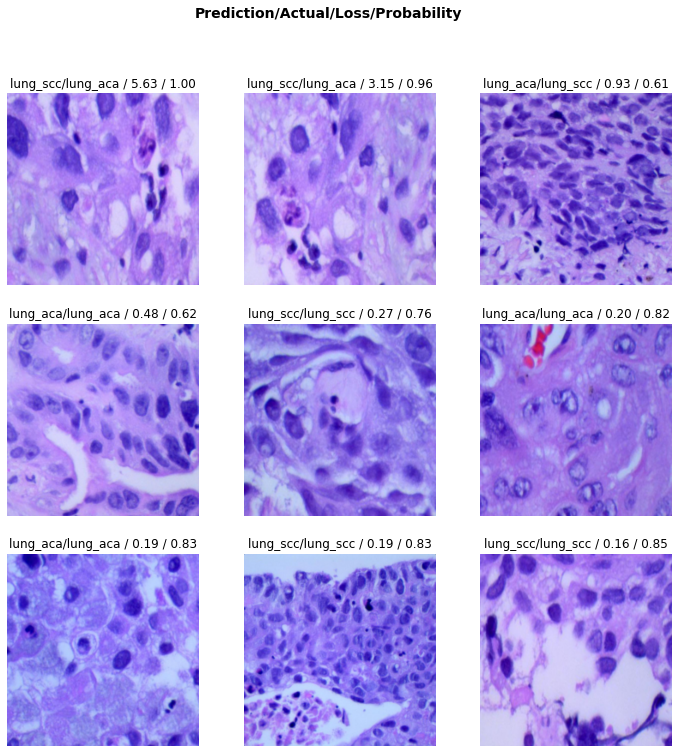

In [21]:
interp.plot_top_losses(9, figsize=(12,12))

Alternatively, we can use "ImageClassifierCleaner" to view the highest-loss images to allow for removal or relabeling.

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Our highest-loss images do not look to be misclassified or labeled incorrectly. We should not make any adjustments.

Satisfied with our model, we can export it for deployment.

In [ ]:
learn.export('lung.pkl')

## Note for Rahul: This was all done in Colab. Trying to fill out the wrangling and EDA prcocess as much as possible. Dataset is already pretty clean, but had to upload/format etc. I'd like to consider this first pass including the model as part of the eda process. Because the data is visual, I think it helps to model it and see where there are obvious mistakes, if any, and adjust.

## In the second section, I'd like to try a few Pytorch image models, using a single model from a number of families (resnet, levit, convnext, regnet.) I'll also attempt to train the best model from scratch to see how it compares to transfer learning. I'll create a final confusion matrix and confirm my model selection. That being said, my first model using transfer learning with resnet seems to be very accurate.

## In the next section I'll also be configuring gradio, creating a python script for hugging face, pushing everything to hugging face for deployment, and trying the interface out.

## The steps seem a little less clear-cut working with image data compared to tabular data, but doing my best.